In [55]:
import pandas as pd
import numpy as np
from copy import copy
import importlib
import CF_functions
importlib.reload(CF_functions)
from CF_functions import *
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\wz369\Anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Data

In [71]:
# READING SAVED DATA
org_data = pd.read_pickle('data/data.pkl')

# REFORMAT DATA - WIDE DESIGN MATRIX
# mle_data = copy(data[['Binary','Group','Revenue year','Size','Price']])
mle_data = copy(org_data[['Binary','Group','Revenue year','Size','Price','Nview','Age','New']])
# LOGALIZE NVIEW,AGE
mle_data['Nview'] = np.log(mle_data['Nview']+1)
mle_data['Age'] = np.log(mle_data['Age'])
mle_data = mle_data.dropna()
# WIDEN
groups = pd.get_dummies(mle_data['Group'])
mle_data['Medium'] = groups.iloc[:,1] 
mle_data['Large'] = groups.iloc[:,2]
times = pd.get_dummies(mle_data['Revenue year'])
mle_data['Year'] = times.iloc[:,1]

c1, c2 = 3490, 748
mle_data['Cost'] = (c1 + c2 * mle_data.Size) * mle_data.Binary / 1e6
mle_data['Revenue'] = mle_data.Binary * mle_data.Price * mle_data.Size / 1e6

group = [0, 10, 20, 50, 100]
# group = [0, 20, 50]
groups = np.zeros(len(mle_data.Size))
for i, lb in enumerate(group):
    # Assign group based on Qbar_it and the group thresholds;
    # Greater size, larger group number
    groups[mle_data.Size >= lb] = int(i)
mle_data['Group'] = groups

mle_data2021 = mle_data.loc[mle_data.Year == 1, ['Binary', 'Cost', 'Revenue', 'Group']]
mle_data2021['Profit'] = mle_data2021.Revenue - mle_data2021.Cost
mle_data2021['Value'] = 'Original'

C:\Users\wz369\Anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [72]:
mle_data2021.head()

,Binary,Cost,Revenue,Group,Profit,Value
1,0,0.0,0.0,4.0,0.0,Original
3,0,0.0,0.0,4.0,0.0,Original
5,1,0.176278,0.5313,4.0,0.355022,Original
7,0,0.0,0.0,4.0,0.0,Original
11,0,0.0,0.0,4.0,0.0,Original


# Model Fit

In [73]:
fixed = 0.65
x = [ 2.22674415e+03, -5.49937040e+02, -6.66158998e+02,  1.80445730e+02, -4.32924199e+01,  8.05901134e+01,  2.57653653e-03]
opt_data, tck_nview, s = Value_generation(x)

np.random.seed(1)
m = 10
df = pd.DataFrame(np.repeat(opt_data.values, m, axis=0), columns=opt_data.columns)
SNC_est = splev(np.log(df.Nview.astype('float64') + 1), tck_nview)
SNC_var = np.sum(SNC_est) * (1 - fixed) / np.sum(df.Size)

# INPUT GENERATION: 2020 ====================================
df2020 = copy(df[df.Year == 0].reset_index(drop=True))
v = np.random.logistic(loc=df2020.Value, scale=s)
df2020['v_it'] = v
Qbar_it = df2020.Size
V_it = df2020.v_it
cmat = Consumer_matrix(V_it, Qbar_it)
newrate2020 = np.mean(opt_data['New'].loc[opt_data['Year'] == 0])

## COST ASSUMPTION SELECTION  --------------------------------
cost = [splev(np.log(df2020.Nview.astype('float64') + 1), tck_nview), newrate2020, fixed, SNC_var]

# INPUT GENERATION: 2021 ====================================
df2021 = copy(df[df.Year==1].reset_index(drop=True))
v = np.random.logistic(loc=df2021.Value,scale=s)
df2021['v_it'] = v
Qbar_it = df2021.Size
V_it = df2021.v_it
cmat = Consumer_matrix(V_it, Qbar_it)
newrate2021 = np.mean(opt_data['New'].loc[opt_data['Year']==1])

## COST ASSUMPTION SELECTION ---------------------------------
cost = [splev(np.log(df2021.Nview.astype('float64') + 1), tck_nview), newrate2021, fixed, SNC_var]

-549.93704 -666.158998


In [74]:
currentQ = [0,9,10,19,20,49,50,99,100,200]
currentP = [2900, 2900, 2700, 2700, 2500, 2500, 2400, 2400, 2300, 2300]
currentY = currentP * np.array(currentQ)
df = Profit(Y=currentY, Q=currentQ, cmat=cmat, cost=cost, continuity=False, group=group)[-1]
df.head()

,Group,Revenue,Cost,Profit,Value,Acceptance
0,4.0,0.046,0.01458,0.03142,Fitted,1
1,4.0,0.046,0.01458,0.03142,Fitted,1
2,4.0,0.046,0.01458,0.03142,Fitted,1
3,4.0,0.000,0.00000,0.00000,Fitted,0
4,4.0,0.000,0.00000,0.00000,Fitted,0


In [75]:
mle_data2021['Value'] = 'Original'
mle_data2021.rename(columns={'Binary': 'Acceptance'}, inplace=True)
compare_df = (pd.concat([df, mle_data2021]).groupby(['Group', 'Value'])
                                           .agg({'Revenue': 'sum', 'Cost': 'sum',
                                                 'Profit': 'sum', 'Acceptance': 'mean'})
                                           .reset_index())
compare_df.Acceptance *= 100
compare_df.rename(columns={'Acceptance': 'Acceptance Rate'}, inplace=True)
compare_df

,Group,Value,Revenue,Cost,Profit,Acceptance Rate
0,0.0,Fitted,10.29558,5.47248,4.8231,49.017769
1,0.0,Original,10.3936,6.348822,4.044778,51.798916
2,1.0,Fitted,6.57639,2.325894,4.250496,59.728916
3,1.0,Original,5.1489,1.974366,3.174534,47.147147
4,2.0,Fitted,7.17975,2.371955,4.807795,42.093023
5,2.0,Original,6.555,2.334686,4.220314,41.472868
6,3.0,Fitted,3.2496,1.031395,2.218205,45.416667
7,3.0,Original,3.7608,1.259366,2.501434,52.083333
8,4.0,Fitted,3.17791,1.015166,2.162744,43.636364
9,4.0,Original,1.9481,0.654496,1.293604,27.272727


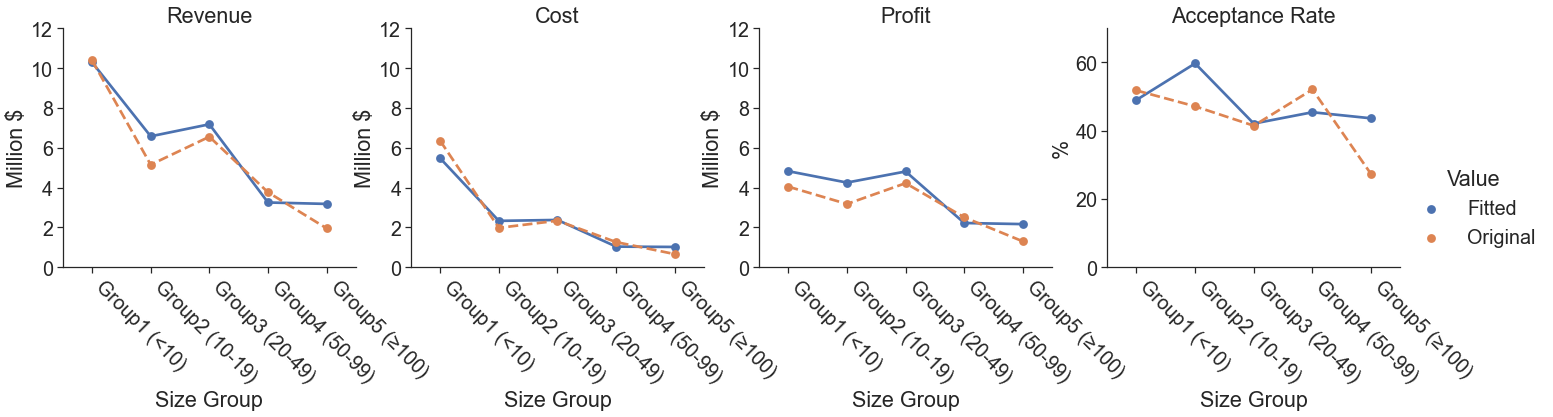

In [76]:
if len(group) == 3:
    xlables = ["Group{}".format(i) for i in ["1 (<10)", "2 (10-49)", "3 (≥50)"]]
elif len(group) == 5:
    xlables = ["Group{}".format(i) for i in ["1 (<10)", "2 (10-19)",
                                             "3 (20-49)", "4 (50-99)",
                                             "5 (≥100)"]]

sns.set(font_scale=1.8)
sns.set_style("ticks")
p = (sns.catplot(data=compare_df.melt(id_vars=['Group', 'Value']),
             x="Group", y="value", hue="Value",
             col="variable", kind="point",
             linestyles=['-', '--'],
             sharey = False)
        .set_titles(col_template="{col_name}")
        .set_xticklabels(xlables)
        .set_xticklabels(rotation=-45, ha='left')
        .set_axis_labels('Size Group'))

ax0, ax1, ax2, ax3 = p.axes[0]
for ax in [ax0, ax1, ax2]:
    ax.set_ylim((0, 12))
    ax.set_ylabel('Million $')
ax3.set_ylim((0, 70))
ax3.set_ylabel('%')

p.savefig("fig/model_fit5.svg", facecolor="w", dpi=400);

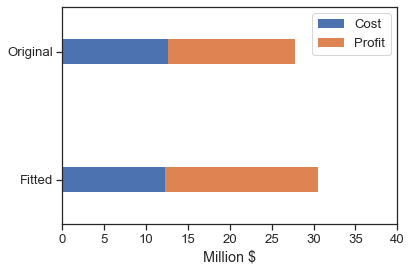

In [70]:
sns.set(font_scale=1.2)
sns.set_style("ticks")
p = compare_df.groupby('Value')[['Cost', 'Profit']].sum().plot(kind='barh', stacked=True,
                                                               width=0.2, ec='none')

plt.ylabel('')
plt.xlabel('Million $')
plt.xlim((0, 40))
plt.legend(loc='upper right')
p.figure.savefig("fig/model_fit_bar.svg", facecolor="w", dpi=400);

Text(0, 0.5, 'Percentage Ranges')

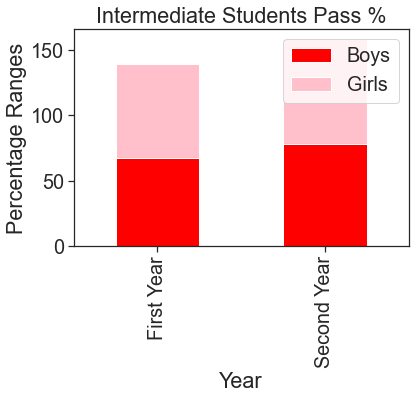

In [9]:
# create DataFrame
students = pd.DataFrame({'Boys': [67, 78],
                         'Girls': [72, 80], },
                        index=['First Year', 'Second Year'])
 

# create stacked bar chart for students DataFrame
students.plot(kind='bar', stacked=True, color=['red', 'pink'])
 
# Add Title and Labels
plt.title('Intermediate Students Pass %')
plt.xlabel('Year')
plt.ylabel('Percentage Ranges')

In [10]:
students

,Boys,Girls
First Year,67,72
Second Year,78,80
